# Počítačová algebra -- cvičení 6

## Úloha 1

In [1]:
R.<x> = ZZ[]

In [2]:
for i in range(15):
    f = R.random_element(20,-10,10)
    g = R.random_element(20,-10,10)
    h = gcd(f,g)
    c = (f//h).resultant(g//h) #prvociselni delitele jsou smolná prvočísla
    d = gcd(f.lc(),g.lc()).prime_factors() #nepouzitelna prvocisla
    if c!=0:
        print(c.prime_factors(),d)
    else:
        print([],d)


[3, 5, 13, 1931, 57317713665297103005547041082128302339] [5]
[2, 31, 47, 83, 17939921, 254123795369, 354346362612892176661] []
[2, 67, 107, 21757, 2595404477, 557011591764656825479549888633] [2]
[3, 7, 11, 13, 71, 23741, 4859829737309263, 1318634815535145660100963] [3]
[2, 3, 7, 67, 97, 1791173, 109982011336882523, 155792966050853809] []
[3, 5, 17, 229, 2233513, 22922243, 7548919943, 334331558165552099] []
[2, 31, 61, 353, 4192427651832402246948127933962796495553] []
[2, 5, 247742691409601, 9391989154079717653603203724429] [2]
[2, 7, 11, 607, 345565060901, 140367132031495823, 382547262491799641] [2]
[2, 3, 5, 107, 303679, 400291773043382359049854910540791727357] []
[7, 947, 629249, 1036349, 1767696276183269, 780095410817659033] []
[2, 5, 4721351, 6837943118014637, 30992473635015120478973] [2]
[2, 5, 13, 17, 3504578593273, 2881713796982043129897746887] [2]
[3, 449, 1237, 3075481099, 2059155406515423160595824724203] []
[2, 7, 67, 147790795288923557, 10399323710797189861037339] []


## Úloha 2

In [3]:
#Computes the Landau-Mignott bound
def LM(f,g):
    m = f.degree()
    n = g.degree()
    res = 2^(min(m,n))*gcd(f.lc(),g.lc())
    res*= min(vector(f.coefficients()).norm()/abs(f.lc()),vector(g.coefficients()).norm()/abs(g.lc()))
    return ceil(res)

In [4]:
f = R.random_element(10,-10,10)
g = R.random_element(10,-10,10)
h = R.random_element(5,-10,10)


print(gcd(f*h,g*h))
print(LM(f*h,g*h))
#Všimněte si, že i když má NSD koeficienty menší než 10, tak je LM mez ze skript v řádu miliónů

10*x^5 + 3*x^4 - 4*x^3 + 7*x^2 + 3*x + 2
2998268


## Úloha 3

Níže je implementace chytřejšího algoritmu z přednášky používajícího více menších prvočísel.

In [5]:
'''Na vstupu je polynom ze Zmod(n)
Vrátí polynom ze ZZ[] podle pravidla tak, že převede koeficienty do intervalu [-(p-1)/2,(p-1)/2]
'''
def change_base_mod_to_ZZ(f,n):
    f = f.change_ring(ZZ)
    coeffs = f.list()
    for i in range(len(coeffs)):
        if coeffs[i] > (n-1)//2:
            coeffs[i] += -n
    return f.parent()(coeffs)

'''
Funkce vracející nejmenší větší prvočíslo než n, které zároveň nedělí d
'''
def next_suitable_prime(n,d):
    p = next_prime(n)
    while d % p == 0:
            p = next_prime(p)
    return p


'''Na vstupu jsou polynomy ze ZZ[]
Fce převede polynomy do Zmod(p)[], spočte tam jejich gcd. 
Převede na polynom s vedoucím členem d.
Převede zpátky do ZZ[] za použití předchozí fce.
'''
def gcd_over_Zp(f,g,p,d):
    h = gcd(f.change_ring(Zmod(p)),g.change_ring(Zmod(p)))
    h = h/h.lc()*d
    h = change_base_mod_to_ZZ(h,p)
    return h


'''Na vstupu jsou polynomy ze ZZ[]
Modulární algoritmus na výpočet GCD z přednášky používající více prvočísel, která postupně skládá pomocí ČZV.
Pokud heuristic, tak nečeká než součin použítých prvočísel přeroste LM, ale místo toho si zkusí tipnout, že je výsledek
správně, pokud se od předchozího kroku nezměnil.
'''
def modular_gcd(f,g,heuristic = False):
    d = gcd(f.lc(),g.lc())
    p = next_suitable_prime(1,d)
    h = gcd_over_Zp(f,g,p,d)
    if h.degree() == 0:
        return 1
    else:
        H = h; P = p
        
    LM_bound = 2*d*LM(f,g)
    times = 0 #how many times we tried to guess the GCD from the fact it did not change
    while True:
        #If we have primes large enough
        if P > LM_bound:
            ppH = H // H.content()
            if ppH.divides(f) and ppH.divides(g):
                #print(P,LM_bound)
                return ppH
            else: #if we found out the previous primes were bad
                p = next_suitable_prime(p,d)
                h = gcd_over_Zp(f,g,p,d)
                if h.degree() == 0:
                    return 1
                else:
                    H = h; P = p
                continue
                
        #next iteration
        p = next_suitable_prime(p,d)
        h = gcd_over_Zp(f,g,p,d)
        
        #if we found out the previous primes were bad
        if h.degree() < H.degree():
            if h.degree() == 0:
                return 1
            else:
                H = h; P = p
            continue
        #if we have a potentially good prime
        if h.degree() == H.degree():
            HH = H +((h-H)*inverse_mod(P,p) % p)*P
            if HH == H and heuristic:
                times +=1
                ppH = H // H.content()
                if ppH.divides(f) and ppH.divides(g):
                    print(P,LM_bound,times)
                    return ppH
                
            H = HH; P = P*p

In [6]:
for i in range(20):
    f = R.random_element(50,-100,100)
    g = R.random_element(50,-100,100)
    h = R.random_element(20,-100,100)
    F = f*h; G = g*h
    F = F // F.content(); G = G//G.content()
    modular_gcd(F,G,True)
    
#V tomto případě je heuristic True a algoritmus vypisuje trojici (P, LM_bound, times), kde 
#P je jaký součin prvočísel mu stačil
# LM_bound je Landau-Mignottova mez
# times je počet zkoušení, které při heuristice musel provést (zkouší jestli je výsledek správný, pokud se po jednom kroku nezměnil)

#Z výsledků jde vidět, že heuristika je velmi dobrá a typicky pokud se výsledek nezměnil, tak už je správný
#Zároveň LM_bound je hrubě nadstřelená stačí daleko menší číslo, kterým modulíme

431 803107229719057720237409200 1
353 298034072056120751062443212 1
431 638793106558815844086116684 1
199 12058752237221689878586200 1
229 1031423835887555085395384754 1
5138835439 27096343372099927219328595720 1
223 321155346296611702742975424 1
227 10911668768924985068583816 1
1117 2384186760630689903096620500 1
739 114411058139596072501479952 1
773 1180964561199138909335610120 1
431 684070440430135538266850044 1
227 271778550924638999239858678 1
1951 4597120837539534057688767448 1
199 32784647331799408332020742 1
974153 3134391278902714080908800380 1
211 164560159410395467398489716 1
223 195053780476397986058386776 1
223 250744529806138721059942464 1
827 1486854932534220333440317920 1


## Úloha 4

In [7]:
R.<x,y> = ZZ[]
S.<t> = R[]
f = t^2+3-x
g = 2-t^4+3*t^3-y^4
h = f.resultant(g)

In [8]:
print("Toto je hledaná implicitní rovnice:")
print(h) 

Toto je hledaná implicitní rovnice:
y^8 + 2*x^2*y^4 - 12*x*y^4 + x^4 + 14*y^4 - 21*x^3 + 131*x^2 - 327*x + 292


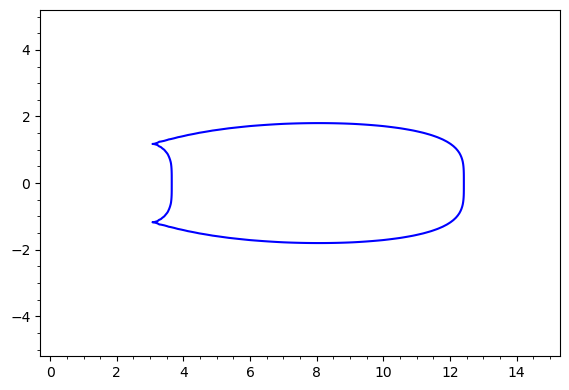

In [9]:
implicit_plot(h,(x,0,15),(y,-5,5))

In [10]:
#Proč tohle funguje? ;)
#Tady je pěkné vysvětlení na Youtube: https://youtu.be/pjnq5LP1ESY